# Brain tumor detection using a CNN

In [121]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

### Parameters

In [122]:
train_dataset_path = './Brain Tumor Data Set/Train'
test_dataset_path = './Brain Tumor Data Set/Test'
batch_size = 32
img_height = 128
img_width = 128
seed = 42

## Let's load our data

In [123]:
# Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.


In [124]:
# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4514 files belonging to 2 classes.
Using 902 files for validation.


In [125]:
# Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.


In [126]:
class_names = train_ds.class_names
print(class_names)

['Cancer', 'Not cancer']


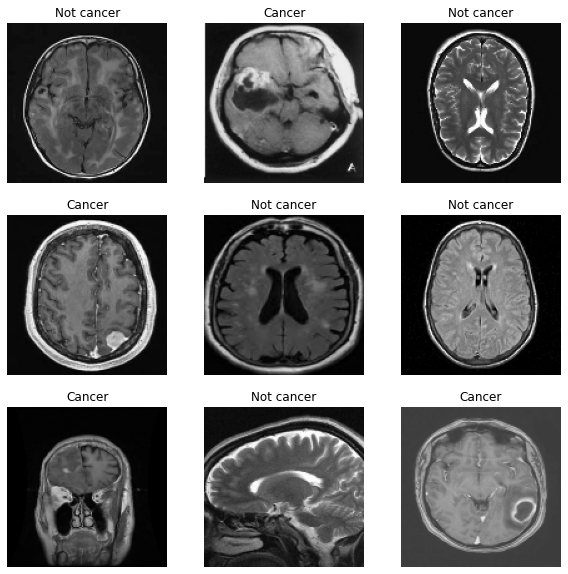

In [127]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Now it's time to train!

In [128]:
# Some optimization settings
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [129]:
# Setup the model pipeline
model = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Conv2D(8, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(16, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(rate=0.3),
  Dense(64, activation='relu'),
  Dropout(rate=0.3),
  Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)      

In [25]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

history = model.fit(
    train_ds,
    verbose=1,
    callbacks = [earlystopping],
    epochs=10,
    validation_data=val_ds)

Epoch 1/10
113/113 [==============================] - 31s 264ms/step - loss: 1.7323 - accuracy: 0.6730 - val_loss: 0.4274 - val_accuracy: 0.7938
Epoch 2/10
113/113 [==============================] - 22s 198ms/step - loss: 0.3901 - accuracy: 0.8192 - val_loss: 0.2984 - val_accuracy: 0.8880
Epoch 3/10
113/113 [==============================] - 22s 196ms/step - loss: 0.2818 - accuracy: 0.8887 - val_loss: 0.2398 - val_accuracy: 0.9169
Epoch 4/10
113/113 [==============================] - 23s 200ms/step - loss: 0.1919 - accuracy: 0.9269 - val_loss: 0.1608 - val_accuracy: 0.9479
Epoch 5/10
113/113 [==============================] - 22s 196ms/step - loss: 0.1266 - accuracy: 0.9540 - val_loss: 0.1674 - val_accuracy: 0.9390
Epoch 6/10
113/113 [==============================] - 23s 202ms/step - loss: 0.1011 - accuracy: 0.9629 - val_loss: 0.0949 - val_accuracy: 0.9734
Epoch 7/10
113/113 [==============================] - 23s 201ms/step - loss: 0.0755 - accuracy: 0.9734 - val_loss: 0.1079 - val_ac

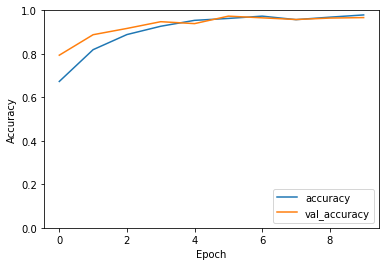

In [26]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

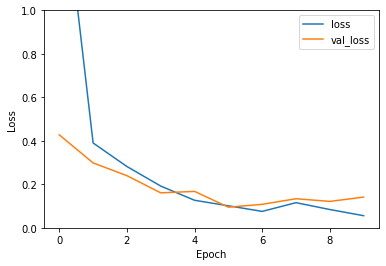

In [28]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

## Let's evaluate our model

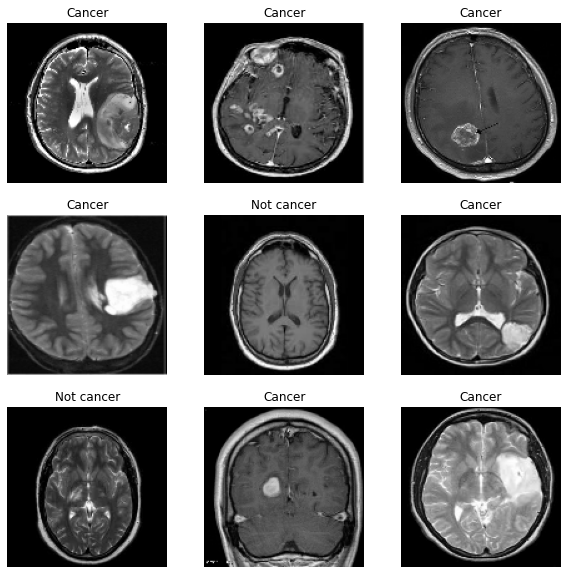

In [119]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [118]:
eval_out = model.evaluate(test_ds,
                          verbose=1)

print('Accuracy: {} \nLoss: {}'.format(round(eval_out[1], 2), round(eval_out[0], 2)))

8/8 [==============================] - 1s 67ms/step - loss: 0.0520 - accuracy: 0.9881
Accuracy: 0.99 
Loss: 0.05


## Let's try our model

1/1 [==============================] - 0s 100ms/step


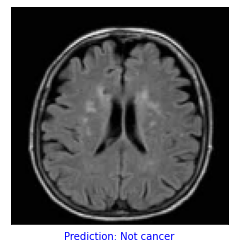

In [111]:
index_to_test = 0

for images, labels in test_ds.take(1):
  test_image = images[index_to_test]
  test_image_class = labels[index_to_test]

predictions = model.predict(np.expand_dims(test_image, 0))

# Let's visualize the prediction
predicted_value = round(predictions[0][0])
true_value = tf.get_static_value(test_image_class)
label_color = 'blue' if predicted_value == true_value else 'red'

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel("Prediction: {}".format(class_names[predicted_value]), color=label_color)
plt.imshow(test_image/255);
